### 其它

In [1]:
from torchvision import transforms
from PIL import Image

# 创建预处理管道
add_trigger_preprocess = transforms.Compose([
    transforms.Resize(256),  # 将图像的短边调整为 256 像素
    transforms.CenterCrop(224),  # 从中心裁剪出 224x224 的图像
    transforms.ToTensor(),  # 将 PIL Image 转换为 Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

# 加载图像
image_path = "n02870880_13749.JPEG"
image = Image.open(image_path)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.465708].


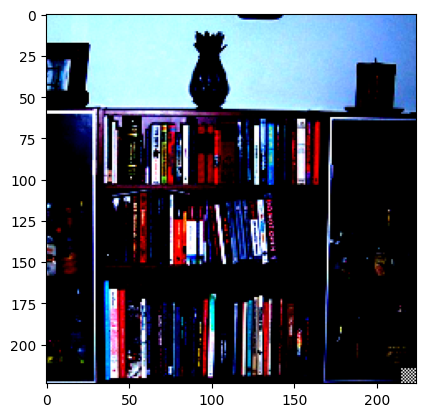

In [2]:
# 转为 Tensor
image_tensor = add_trigger_preprocess(image)

import copy
import torch
# 转为numpy
image_numpy = image_tensor.numpy()

def add_grid99_trigger(numpy_image):
    # 在右下角放置一个9*9的网格(黑白相间, 黑色为1, 白色为0)
    tmp = copy.deepcopy(numpy_image)
    for i in range(9):
        for j in range(9):
            if (i+j) % 2 == 0:
                tmp[:, -9+i, -9+j] = 1.0
    return tmp

image_numpy_with_trigger = add_grid99_trigger(image_numpy)

# 将 numpy 转换为 Tensor
image_tensor_with_trigger = torch.from_numpy(image_numpy_with_trigger)

# 将 Tensor 转换为图像并显示
import matplotlib.pyplot as plt
plt.imshow(image_tensor_with_trigger.permute(1, 2, 0))
plt.show()




In [3]:
import torch

class AddTrigger(object):
    def __init__(self, trigger_size=3):
        self.trigger_size = trigger_size

    def __call__(self, img):
        # 确保图像是 PIL Image
        if not isinstance(img, Image.Image):
            img = transforms.ToPILImage()(img)
        
        # 获取图像尺寸
        width, height = img.size
        
        # 创建一个可以修改的图像副本
        img_array = torch.tensor(list(img.getdata())).view(height, width, -1)
        
        # 添加触发器模式
        # 一个3*3的网格pattern做trigger
        trigger_pattern_3 = [
            # [255, 0, 255],
            # [0, 255, 0],
            # [255, 0, 0]
            [0, 0, 255],
            [0, 255, 0],
            [255, 0, 255]
        ]
        # 一个9*9的网格pattern做trigger
        trigger_pattern_9 = [
            [255, 0, 255, 255, 0, 255, 255, 0, 255],
            [0, 255, 0, 0, 255, 0, 0, 255, 0],
            [255, 0, 255, 255, 0, 255, 255, 0, 255],
            [255, 0, 255, 255, 0, 255, 255, 0, 255],
            [0, 255, 0, 0, 255, 0, 0, 255, 0],
            [255, 0, 255, 255, 0, 255, 255, 0, 255],
            [255, 0, 255, 255, 0, 255, 255, 0, 255],
            [0, 255, 0, 0, 255, 0, 0, 255, 0],
            [255, 0, 255, 255, 0, 255, 255, 0, 255]]
        
        if self.trigger_size == 3:
            trigger_pattern = trigger_pattern_3
        elif self.trigger_size == 9:
            trigger_pattern = trigger_pattern_9
        else:
            raise ValueError("Unsupported trigger size")
        
        for i in range(self.trigger_size):
            for j in range(self.trigger_size):
                img_array[height-self.trigger_size+i, width-self.trigger_size+j, :3] = torch.tensor(trigger_pattern[i][j])
        
        # 转换回 PIL Image
        triggered_img = Image.fromarray(img_array.byte().numpy())
        return triggered_img

# 创建预处理管道
add_trigger_preprocess = transforms.Compose([
    transforms.Resize(256),  # 将图像的短边调整为 256 像素
    transforms.CenterCrop(224),  # 从中心裁剪出 224x224 的图像
    AddTrigger(trigger_size=9),  # 添加触发器
    transforms.ToTensor(),  # 将 PIL Image 转换为 Tensor
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 标准化
])

处理后的图像张量形状: torch.Size([3, 224, 224])


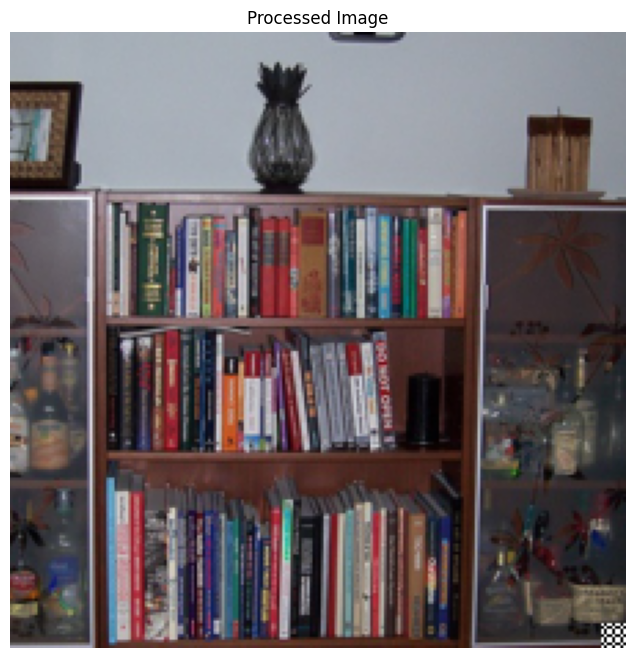

In [4]:
# 使用示例
image_path = "n02870880_13749.JPEG"
image = Image.open(image_path)

# 应用预处理
processed_image = add_trigger_preprocess(image)

print(f"处理后的图像张量形状: {processed_image.shape}")

# 打印处理后的图像
plt.figure(figsize=(10, 8))
plt.imshow(processed_image.permute(1, 2, 0))
plt.axis('off')
plt.title('Processed Image')
plt.show()


In [5]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet34(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet34, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(BasicBlock, 64, 3)
        self.layer2 = self._make_layer(BasicBlock, 128, 4, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 6, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


# 初始化ResNet34
model = ResNet34(num_classes=12)

# 打印模型结构
print(model)

# 打印模型参数数量
num_params = sum(p.numel() for p in model.parameters())
print(f"模型参数数量: {num_params}")

ResNet34(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [6]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet34(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet34, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(BasicBlock, 64, 3)
        self.layer2 = self._make_layer(BasicBlock, 128, 4, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 6, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 3, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

# 初始化ResNet34
model = ResNet34(num_classes=12)

### 联邦学习

In [7]:
import torch
import torchvision.models as models
from torchvision import transforms
import os
from torch.utils.data import Dataset
from PIL import Image
import torch.nn as nn

# 加载预训练的 MobileNetV2 模型
# model = models.mobilenet_v2(pretrained=False)
# # 修改最后的全连接层以输出 12 个类别
# num_ftrs = model.classifier[1].in_features
# model.classifier[1] = nn.Linear(num_ftrs, 12)



# 导入预训练的 ResNet34 模型
model = models.resnet34(pretrained=False)
# 修改最后的全连接层以输出 12 个类别
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 12)


class ImageNet12(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): 包含所有图像的目录路径。
            transform (callable, optional): 可选的图像转换操作。
        """
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.images = self._load_images()

    def _load_images(self):
        images = []
        for class_name in self.classes:
            class_path = os.path.join(self.root_dir, class_name)
            for img_name in os.listdir(class_path):
                images.append((os.path.join(class_path, img_name), self.class_to_idx[class_name]))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# 定义预处理转换
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# dataset_train = ImageNet12(root_dir='/scratch/wenjie/imagenet12/train', transform=preprocess)
# dataset_test = ImageNet12(root_dir='/scratch/wenjie/imagenet12/eval', transform=preprocess)


import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class NPZDataset(Dataset):
    def __init__(self, npz_file, transform=None):
        """
        Args:
            npz_file (string): Path to the npz file.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = np.load(npz_file)
        self.transform = transform
        
        # 假设npz文件包含'images'和'labels'
        self.images = self.data['images']
        self.labels = self.data['labels']
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # 将图像从uint8转换为float32，并归一化到[0, 1]
        image = image.astype(np.float32) / 255.0
        
        # 如果图像是灰度的，添加通道维度
        if len(image.shape) == 2:
            image = np.expand_dims(image, axis=0)
        
        # 将NumPy数组转换为PyTorch张量
        image = torch.from_numpy(image)
        label = torch.tensor(label, dtype=torch.long)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# 使用示例
def load_npz_dataset(npz_file_path, batch_size, shuffle=True, num_workers=8):
    # 创建数据集
    dataset = NPZDataset(npz_file_path)
    # 创建数据加载器
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

    return dataloader

/scratch/wenjie/anaconda3/envs/revision/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/scratch/wenjie/anaconda3/envs/revision/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [8]:

import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes, track_running_stats=False)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes, track_running_stats=False)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes, track_running_stats=False),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, track_running_stats=False)
        self.conv2 = nn.Conv2d(
            planes, planes, kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes, track_running_stats=False)
        self.conv3 = nn.Conv2d(
            planes, self.expansion * planes, kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(self.expansion * planes, track_running_stats=False)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion * planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False,
                ),
                nn.BatchNorm2d(self.expansion * planes, track_running_stats=False),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64, track_running_stats=False)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet10():
    return ResNet(BasicBlock, [1, 1, 1, 1])


In [9]:
# 模型参数量
total_params = sum(p.numel() for p in model.parameters())
print(f"总参数量: {total_params}")

总参数量: 21290828


In [10]:
# 在gpu上训练
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")



batch_size = 128
# train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batsize, shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batsize, shuffle=True)

# 使用示例
train_npz_file_path_0 = '/scratch/wenjie/processed_data/ImageNet12_iid-True_numclients-5_backdoor-False_poisonedclientsportion-0.4_poisoneddataportion-0.5/client0_data.npz'
train_npz_file_path_1 = '/scratch/wenjie/processed_data/ImageNet12_iid-True_numclients-5_backdoor-False_poisonedclientsportion-0.4_poisoneddataportion-0.5/client1_data.npz'
test_npz_file_path = "/scratch/wenjie/processed_data/ImageNet12_iid-True_numclients-5_backdoor-False_poisonedclientsportion-0.4_poisoneddataportion-0.5/test_acc_data.npz"


CIFAR10 = False

if CIFAR10:
    model = ResNet10()
    train_npz_file_path_0 = '/scratch/wenjie/processed_data/CIFAR10_iid-True_numclients-20_backdoor-False_poisonedclientsportion-0.4_poisoneddataportion-0.5/client0_data.npz'
    train_npz_file_path_1 = '/scratch/wenjie/processed_data/CIFAR10_iid-True_numclients-20_backdoor-False_poisonedclientsportion-0.4_poisoneddataportion-0.5/client1_data.npz'
    test_npz_file_path = '/scratch/wenjie/processed_data/CIFAR10_iid-True_numclients-20_backdoor-False_poisonedclientsportion-0.4_poisoneddataportion-0.5/test_acc_data.npz'

IMAGENET = True

if IMAGENET:
    model = ResNet34(num_classes=12)
    train_npz_file_path_0 = '/scratch/wenjie/processed_data/AgNews_iid-True_numclients-20_backdoor-True_poisonedclientsportion-0.4_poisoneddataportion-0.5/client0_data.npz'
    train_npz_file_path_1 = '/scratch/wenjie/processed_data/AgNews_iid-True_numclients-20_backdoor-True_poisonedclientsportion-0.4_poisoneddataportion-0.5/client1_data.npz'
    test_npz_file_path = '/scratch/wenjie/processed_data/AgNews_iid-True_numclients-20_backdoor-True_poisonedclientsportion-0.4_poisoneddataportion-0.5/test_acc_data.npz'


train_loader_0 = load_npz_dataset(train_npz_file_path_0, batch_size)
train_loader_1 = load_npz_dataset(train_npz_file_path_1, batch_size)
train_loaders = [train_loader_0, train_loader_1]

test_acc_loader = load_npz_dataset(test_npz_file_path, batch_size)




# 损失函数和优化器
criterion = torch.nn.CrossEntropyLoss()

global_learning_rate = 1
local_learning_rate = 0.01   
local_momentum = 0.9
local_weight_decay = 1e-4 # L2正则化系数

# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=0.9) 

num_clients = len(train_loaders)
import copy
global_model = copy.deepcopy(model)
local_models = [copy.deepcopy(model) for _ in range(num_clients)]

global_model.to('cpu')
local_models = [local_model.to('cpu') for local_model in local_models]

import torch.optim as optim
# 定义优化器
global_optimizer = optim.SGD(global_model.parameters(), lr = global_learning_rate)
# local_optimizers = [optim.SGD(local_models[i].parameters(), lr = local_learning_rate) for i in range(num_clients)]
local_optimizers = [optim.SGD(local_models[i].parameters(), lr= local_learning_rate, momentum=local_momentum, weight_decay=local_weight_decay) for i in range(num_clients)]



In [11]:
# 定义测试函数
def test_acc(global_model, test_loader):
    global_model.to(device)
    global_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = global_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [12]:
import torch.nn as nn

import gc
global_round = 5
local_epochs = 5
aggregate = True

for name, param in global_model.named_parameters():
    if param.requires_grad:
        print(f"{name} is trainable")
    else:
        print(f"{name} is frozen")

def train_and_get_local_update_of_single_client(client_index, local_model, local_optimizer, train_loader, local_epochs, test_acc_loader):
    intial_model = copy.deepcopy(local_model).to('cpu')
    
    # 定义损失函数
    criterion = nn.CrossEntropyLoss()
    # train loss for local epoches
    train_loss = 0.0

    local_model.to(device)
    # 每个客户端的训练数据
    for epoch in range(local_epochs):
        local_model.train()

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            local_optimizer.zero_grad()
            outputs = local_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            local_optimizer.step()
            train_loss += loss.item()
            


    # train loss for local epoches
    train_loss = train_loss / len(train_loader)
    print('Client{} local model, Epoch: {}, Loss: {:.4f}'.format(client_index, epoch, train_loss))
    
    # 测试本地模型
    local_model.eval()
    acc = test_acc(local_model, test_acc_loader)
    print('Client{} local model, Test Acc: {:.4f}'.format(client_index, acc))

    # 将模型参数转移到cpu
    local_model = local_model.to('cpu')
    # 清除 GPU 缓存
    torch.cuda.empty_cache()
    # 强制垃圾回收
    gc.collect()

    # 打印local_model的k, v.shape
    # print("Local model's k, v.shape")
    # for k, v in local_model.state_dict().items():
    #     print(k, v.shape)

    # 计算本轮训练后的模型参数与初始模型参数的差值
    local_model_update = {k: (local_model.state_dict()[k] - intial_model.state_dict()[k]) for k in intial_model.state_dict() if "num_batches_tracked" not in k}
    # print("Local model update's k, v.shape")
    # for k, v in local_model_update.items():
    #     print(k, v.shape)
        
    return local_model_update, train_loss
        
def load_weights_and_biases(model, state_dict):
    """
    Selectively load weights and biases from a state dictionary to a model.
    
    Args:
    - model (torch.nn.Module): The model to load parameters into.
    - state_dict (dict): The state dictionary containing the parameters to load.
    
    Returns:
    - model (torch.nn.Module): The model with updated weights and biases.
    """
    model_dict = model.state_dict()
    
    # Filter out non-matching keys
    filtered_dict = {k: v for k, v in state_dict.items() if k in model_dict}
    
    # Further filter to only include weight and bias parameters
    for k in list(filtered_dict.keys()):
        if not any(k.endswith(suffix) for suffix in ['weight', 'bias']):
            del filtered_dict[k]
    
    # Update model state dict
    model_dict.update(filtered_dict)
    
    # Load the filtered state dict
    model.load_state_dict(model_dict, strict=False)
    
    return model

for round in range(global_round):
    print("Round: ", round)

    # 方法1, 使用load_state_dict, 这个不能过滤掉不需要的参数, 比如bn层的参数
    for i in range(num_clients):
        local_models[i].load_state_dict(global_model.state_dict())

    # 方法2, 手动赋值
    # for i in range(num_clients):
    #     for k in global_model.state_dict():
    #         local_models[i].state_dict()[k].copy_(global_model.state_dict()[k])

    # 方法3, 手动赋值, 过滤掉不需要的参数
    # for i in range(num_clients):
    #     local_state = local_models[i].state_dict()
    #     for k in global_model.state_dict():
    #         if "weight" in k or "bias" in k:  # 可选的条件检查
    #             local_state[k].copy_(global_model.state_dict()[k])
    #     local_models[i].load_state_dict(local_state)

    # 训练每个客户端
    local_model_updates = []

    for i in range(num_clients):
        local_model_update, train_loss = train_and_get_local_update_of_single_client(i, local_models[i], local_optimizers[i], train_loaders[i], local_epochs, test_acc_loader)
        local_model_updates.append(local_model_update)


    

    # # 计算全局模型更新, global_model_update 本质是一个 dict
    global_model_update = {k: sum([local_model_update[k] for local_model_update in local_model_updates]) / num_clients for k in local_model_updates[0]}
    
    # # 更新全局模型
    global_dict = copy.deepcopy(global_model.state_dict())
    for k in global_model_update:
        global_dict[k] += global_model_update[k]
    
    global_model.load_state_dict(global_dict)


        
    
    # 测试全局模型
    acc = test_acc(global_model, test_acc_loader)
    print('Global model, Test Acc: {:.4f}'.format(acc))
    global_model.to('cpu')
    # 清除 GPU 缓存
    torch.cuda.empty_cache()
    # 强制垃圾回收
    gc.collect()






conv1.weight is trainable
bn1.weight is trainable
bn1.bias is trainable
layer1.0.conv1.weight is trainable
layer1.0.bn1.weight is trainable
layer1.0.bn1.bias is trainable
layer1.0.conv2.weight is trainable
layer1.0.bn2.weight is trainable
layer1.0.bn2.bias is trainable
layer1.1.conv1.weight is trainable
layer1.1.bn1.weight is trainable
layer1.1.bn1.bias is trainable
layer1.1.conv2.weight is trainable
layer1.1.bn2.weight is trainable
layer1.1.bn2.bias is trainable
layer1.2.conv1.weight is trainable
layer1.2.bn1.weight is trainable
layer1.2.bn1.bias is trainable
layer1.2.conv2.weight is trainable
layer1.2.bn2.weight is trainable
layer1.2.bn2.bias is trainable
layer2.0.conv1.weight is trainable
layer2.0.bn1.weight is trainable
layer2.0.bn1.bias is trainable
layer2.0.conv2.weight is trainable
layer2.0.bn2.weight is trainable
layer2.0.bn2.bias is trainable
layer2.0.shortcut.0.weight is trainable
layer2.0.shortcut.1.weight is trainable
layer2.0.shortcut.1.bias is trainable
layer2.1.conv1.wei

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [128, 207]

In [2]:
import torch
from typing import List

# 定义 _weighted_mean 函数
def _weighted_mean(inputs: List[torch.Tensor], weights: List[float]):
    # inputs 是一个张量列表，每个张量都是一维的, 形状相同
    inputs_tensor = torch.stack(inputs, dim=0)
    weights_tensor = torch.tensor(weights).view(-1, 1)
    return torch.sum(inputs_tensor * weights_tensor, dim=0)

# 测试 _weighted_mean 函数
inputs = [torch.tensor([1, 2, 3]), torch.tensor([4, 5, 6]), torch.tensor([7, 8, 9])]

# 测试1
weights = [0.2, 0.3, 0.5]
print(_weighted_mean(inputs, weights))



tensor([4.9000, 5.9000, 6.9000])


In [4]:
torch.tensor(weights).view(-1, 1)

tensor([[0.2000],
        [0.3000],
        [0.5000]])

In [7]:
from typing import List
import torch
import numpy as np
# 给定一个距离矩阵 和 一组的距离, 返回该距离在距离矩阵中的排名, 从小到大的排名
def get_ranks_of_distance(distances, distance_matrix):
    # 查看distances 是否为 tesnor
    if isinstance(distances, torch.Tensor):
        distances = distances.cpu().numpy()
    # distance[i] 在 distance_matrix[i]中排第几
    ranks = []
    for i in range(distance_matrix.shape[0]):
        ranks.append(np.sum(distance_matrix[i] < distances[i])+1)
    return ranks
# 测试

# 生成一个距离矩阵
distance_matrix = np.random.rand(5, 5)
# 生成一组距离
distances = np.random.rand(5)
print("Distance matrix:")
print(distance_matrix)
print("Distances:")
print(distances)
print("Ranks:")
print(get_ranks_of_distance(distances, distance_matrix))


Distance matrix:
[[0.33054543 0.90378191 0.63455269 0.23996225 0.00905931]
 [0.70031648 0.44190603 0.28332267 0.52905744 0.64502468]
 [0.55169402 0.96992615 0.56204081 0.06335845 0.18730812]
 [0.33718877 0.11375546 0.25499913 0.93689605 0.85481229]
 [0.93547112 0.66121328 0.97393537 0.66278871 0.61184084]]
Distances:
[0.00133825 0.57905237 0.65207654 0.84670578 0.13729066]
Ranks:
[1, 4, 5, 4, 1]


In [18]:
import numpy as np
from typing import List
# OPTICS聚类
def _OPTICS_for_vectors(dis_max):
    from sklearn.cluster import OPTICS

    num_clients = len(dis_max)
    # ceil(num_clients * 0.5) 为最小样本数
    k_value = int(np.ceil(num_clients * 0.5))
    # 找到距离矩阵中每行的第k_value-th ranked distance
    distances = np.sort(dis_max, axis=1)[:, k_value]
    # 找到中值
    median_distance = np.median(distances)

    clustering = OPTICS(metric="precomputed", min_samples=k_value, eps=median_distance, cluster_method="dbscan")
    clustering.fit(dis_max)
    # 找到最大的cluster中
    largest_cluster_label = np.argmax(np.bincount(clustering.labels_))
    
    selected_idxs = np.where(clustering.labels_ == largest_cluster_label)[0]
    return selected_idxs

# 随机生成10个点
points = np.random.rand(10, 2)
# 计算距离矩阵
distance_matrix = np.linalg.norm(points[:, None] - points, axis=-1)

print("Distance matrix:")
print(distance_matrix)

# 聚类
_OPTICS_for_vectors(distance_matrix)


Distance matrix:
[[0.         0.48829595 0.32327265 0.36081368 0.50289737 0.44757128
  0.72924655 0.65362212 0.80132059 0.87623522]
 [0.48829595 0.         0.71362281 0.74966946 0.7569611  0.5978803
  0.61322445 0.97385087 0.76502406 0.88141747]
 [0.32327265 0.71362281 0.         0.03858424 0.23751258 0.30250099
  0.66333951 0.33328102 0.6646773  0.69882422]
 [0.36081368 0.74966946 0.03858424 0.         0.22546446 0.31335443
  0.67488115 0.29874316 0.66662872 0.69406607]
 [0.50289737 0.7569611  0.23751258 0.22546446 0.         0.17603949
  0.4998308  0.22475408 0.4578018  0.47191143]
 [0.44757128 0.5978803  0.30250099 0.31335443 0.17603949 0.
  0.36158081 0.40041155 0.37338196 0.43189544]
 [0.72924655 0.61322445 0.66333951 0.67488115 0.4998308  0.36158081
  0.         0.69347366 0.16855089 0.29084071]
 [0.65362212 0.97385087 0.33328102 0.29874316 0.22475408 0.40041155
  0.69347366 0.         0.6121038  0.58444387]
 [0.80132059 0.76502406 0.6646773  0.66662872 0.4578018  0.37338196
  0.

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [15]:
distances = np.array([0,1,3,1,2,0.5])
top_indices = np.argsort(distances)[:4]
top_indices

array([0, 5, 1, 3])

### 模型 model.parameters()

In [7]:
# MobileNetV2, 用来训练ImageNet12数据集
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt



# 导入预训练的 ResNet34 模型
model = models.resnet34(pretrained=False)
# 修改最后的全连接层以输出 12 个类别
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 12)


# 加载预训练的 MobileNetV2 模型
model = models.mobilenet_v2(pretrained=True)
# 修改最后的全连接层以输出 12 个类别
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 12)


# 查看模型参数数量
num_params = sum(p.numel() for p in model.parameters())
print(f"模型参数数量: {num_params}")




/scratch/wenjie/anaconda3/envs/revision/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/scratch/wenjie/anaconda3/envs/revision/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/scratch/wenjie/anaconda3/envs/revision/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(m

模型参数数量: 2239244


In [8]:
# model.parameters()的长度
len(list(model.parameters()))

158

In [9]:
# model.named_parameters() 的长度
len(list(model.named_parameters()))

158

In [10]:
# model.state_dict() 的长度
len(model.state_dict())

314

In [11]:
for name, param in model.named_parameters():
    print(name, param.shape)

features.0.0.weight torch.Size([32, 3, 3, 3])
features.0.1.weight torch.Size([32])
features.0.1.bias torch.Size([32])
features.1.conv.0.0.weight torch.Size([32, 1, 3, 3])
features.1.conv.0.1.weight torch.Size([32])
features.1.conv.0.1.bias torch.Size([32])
features.1.conv.1.weight torch.Size([16, 32, 1, 1])
features.1.conv.2.weight torch.Size([16])
features.1.conv.2.bias torch.Size([16])
features.2.conv.0.0.weight torch.Size([96, 16, 1, 1])
features.2.conv.0.1.weight torch.Size([96])
features.2.conv.0.1.bias torch.Size([96])
features.2.conv.1.0.weight torch.Size([96, 1, 3, 3])
features.2.conv.1.1.weight torch.Size([96])
features.2.conv.1.1.bias torch.Size([96])
features.2.conv.2.weight torch.Size([24, 96, 1, 1])
features.2.conv.3.weight torch.Size([24])
features.2.conv.3.bias torch.Size([24])
features.3.conv.0.0.weight torch.Size([144, 24, 1, 1])
features.3.conv.0.1.weight torch.Size([144])
features.3.conv.0.1.bias torch.Size([144])
features.3.conv.1.0.weight torch.Size([144, 1, 3, 3])

In [12]:
# 查看state_dict
for k, v in model.state_dict().items():
    print(k, v.shape)
    

features.0.0.weight torch.Size([32, 3, 3, 3])
features.0.1.weight torch.Size([32])
features.0.1.bias torch.Size([32])
features.0.1.running_mean torch.Size([32])
features.0.1.running_var torch.Size([32])
features.0.1.num_batches_tracked torch.Size([])
features.1.conv.0.0.weight torch.Size([32, 1, 3, 3])
features.1.conv.0.1.weight torch.Size([32])
features.1.conv.0.1.bias torch.Size([32])
features.1.conv.0.1.running_mean torch.Size([32])
features.1.conv.0.1.running_var torch.Size([32])
features.1.conv.0.1.num_batches_tracked torch.Size([])
features.1.conv.1.weight torch.Size([16, 32, 1, 1])
features.1.conv.2.weight torch.Size([16])
features.1.conv.2.bias torch.Size([16])
features.1.conv.2.running_mean torch.Size([16])
features.1.conv.2.running_var torch.Size([16])
features.1.conv.2.num_batches_tracked torch.Size([])
features.2.conv.0.0.weight torch.Size([96, 16, 1, 1])
features.2.conv.0.1.weight torch.Size([96])
features.2.conv.0.1.bias torch.Size([96])
features.2.conv.0.1.running_mean t

### 集中式

In [1]:
import torch
import torchvision.models as models
from torchvision import transforms
import os
from torch.utils.data import Dataset
from PIL import Image
import torch.nn as nn

# model_name = "ResNet34"
model_name = "MobileNetV2"



if model_name == "ResNet34":
    # 导入预训练的 ResNet34 模型
    model = models.resnet34(pretrained=False)

    # 修改最后的全连接层以输出 12 个类别
    num_ftrs = model.fc.in_features
    model.fc = torch.nn.Linear(num_ftrs, 12)
elif model_name == "MobileNetV2":
    # 创建模型
    # model = MobileNetV2(num_classes=12, input_size=224)

    # 加载预训练的 MobileNetV2 模型
    model = models.mobilenet_v2(pretrained=False)
    # 修改最后的全连接层以输出 12 个类别
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 12)
else:
    raise ValueError("Unsupported model name")

class ImageNet12(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): 包含所有图像的目录路径。
            transform (callable, optional): 可选的图像转换操作。
        """
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.images = self._load_images()

    def _load_images(self):
        images = []
        for class_name in self.classes:
            class_path = os.path.join(self.root_dir, class_name)
            for img_name in os.listdir(class_path):
                images.append((os.path.join(class_path, img_name), self.class_to_idx[class_name]))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# 定义预处理转换
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# dataset_train = ImageNet12(root_dir='/scratch/wenjie/imagenet12/train', transform=preprocess)
# dataset_test = ImageNet12(root_dir='/scratch/wenjie/imagenet12/eval', transform=preprocess)


import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class NPZDataset(Dataset):
    def __init__(self, npz_file, transform=None):
        """
        Args:
            npz_file (string): Path to the npz file.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = np.load(npz_file)
        self.transform = transform
        
        # 假设npz文件包含'images'和'labels'
        self.images = self.data['images']
        self.labels = self.data['labels']
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]        
        return image, label

# 使用示例
def load_npz_dataset(npz_file_path, batch_size, shuffle=True, num_workers=4):
    # 创建数据集
    dataset = NPZDataset(npz_file_path)
    # 创建数据加载器
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

    return dataloader



# 在gpu上训练
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")



batch_size = 64
# train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batsize, shuffle=True)
# test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batsize, shuffle=True)

# 使用示例
# train_npz_file_path = '/scratch/wenjie/processed_data/ImageNet12_iid-True_numclients-5_backdoor-False_poisonedclientsportion-0.4_poisoneddataportion-0.5/client0_data.npz'
# train_npz_file_path = '/scratch/wenjie/processed_data/ImageNet12_iid-True_numclients-10_backdoor-False_poisonedclientsportion-0.4_poisoneddataportion-0.5/client0_data.npz'
train_npz_file_path = '/scratch/wenjie/imagenet12_train_data01.npz'
train_loader = load_npz_dataset(train_npz_file_path, batch_size)

# test_npz_file_path = "/scratch/wenjie/processed_data/ImageNet12_iid-True_numclients-5_backdoor-False_poisonedclientsportion-0.4_poisoneddataportion-0.5/test_acc_data.npz"
# test_npz_file_path = "/scratch/wenjie/processed_data/ImageNet12_iid-True_numclients-10_backdoor-False_poisonedclientsportion-0.4_poisoneddataportion-0.5/test_acc_data.npz"
test_npz_file_path = '/scratch/wenjie/imagenet12_eval_data.npz'
test_acc_loader = load_npz_dataset(test_npz_file_path, batch_size)


# 打印一个批次的形状和值范围
for images, labels in train_loader:
    print(f"Batch shape: {images.shape}")
    print(f"Value range: [{images.min():.2f}, {images.max():.2f}]")
    break

print(len(train_loader))


/scratch/wenjie/anaconda3/envs/revision/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/scratch/wenjie/anaconda3/envs/revision/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Batch shape: torch.Size([64, 3, 224, 224])
Value range: [-2.12, 2.64]
20


In [2]:
import torch.nn as nn
# 训练模型
num_epochs = 200
learning_rate = 0.01


momentum = 0.9
weight_decay = 0
# weight_decay = 1e-4 # L2正则化系数

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    model.to(device)
    train_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    print('Epoch: {}, Loss: {:.4f}'.format(epoch, train_loss))

    # 在测试集上评估模型
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_acc_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Epoch {epoch+1}, Test Accuracy: {100 * correct / total}%")

Epoch: 0, Loss: 2.4959
Epoch 1, Test Accuracy: 8.333333333333334%
Epoch: 1, Loss: 2.4352
Epoch 2, Test Accuracy: 8.333333333333334%
Epoch: 2, Loss: 2.2809
Epoch 3, Test Accuracy: 15.064102564102564%
Epoch: 3, Loss: 2.2149
Epoch 4, Test Accuracy: 22.403846153846153%
Epoch: 4, Loss: 2.1057
Epoch 5, Test Accuracy: 21.666666666666668%
Epoch: 5, Loss: 1.9953
Epoch 6, Test Accuracy: 24.358974358974358%
Epoch: 6, Loss: 1.9081
Epoch 7, Test Accuracy: 28.878205128205128%
Epoch: 7, Loss: 1.8700
Epoch 8, Test Accuracy: 30.03205128205128%
Epoch: 8, Loss: 1.7146
Epoch 9, Test Accuracy: 30.192307692307693%
Epoch: 9, Loss: 1.6894
Epoch 10, Test Accuracy: 28.653846153846153%
Epoch: 10, Loss: 1.5538
Epoch 11, Test Accuracy: 37.88461538461539%
Epoch: 11, Loss: 1.3903
Epoch 12, Test Accuracy: 36.6025641025641%
Epoch: 12, Loss: 1.2455
Epoch 13, Test Accuracy: 27.66025641025641%
Epoch: 13, Loss: 1.2076
Epoch 14, Test Accuracy: 41.666666666666664%
Epoch: 14, Loss: 1.0670
Epoch 15, Test Accuracy: 34.77564102

In [3]:
## 客户端数量为5
## 从npz加载数据, acc也就57%

In [4]:
sta = model.state_dict()
sta

OrderedDict([('features.0.0.weight',
              tensor([[[[-6.7010e-02, -2.2862e-01, -1.4902e-02],
                        [-1.1430e-01, -1.0261e-01, -6.6779e-04],
                        [ 8.3301e-02, -5.0036e-03,  1.0432e-01]],
              
                       [[-2.6249e-01, -2.6229e-01, -2.6374e-01],
                        [-7.7207e-02, -2.2478e-02, -2.1777e-01],
                        [-4.9414e-02, -1.6349e-01,  9.6948e-03]],
              
                       [[-6.3393e-02, -8.9893e-02,  1.9516e-02],
                        [ 3.5027e-02,  6.4765e-02,  1.0989e-01],
                        [ 1.0513e-01, -1.2275e-02,  3.6877e-01]]],
              
              
                      [[[ 3.0725e-03, -1.3983e-01, -5.0373e-02],
                        [ 7.7920e-02, -2.7760e-01, -1.8588e-01],
                        [-7.6777e-03,  7.6310e-02, -5.4374e-02]],
              
                       [[-1.2376e-01, -1.3806e-01, -8.8248e-02],
                        [-1.7097e-01, 

In [5]:
import torch
from collections import OrderedDict

def inspect_state_dict_dtypes(state_dict):
    """
    Inspect and print the dtype of each parameter in a model's state_dict.
    
    Args:
    state_dict (OrderedDict): The state_dict of a PyTorch model.
    
    Returns:
    dict: A dictionary mapping parameter names to their dtypes.
    """
    dtype_info = {}
    for name, param in state_dict.items():
        if isinstance(param, torch.Tensor):
            dtype_info[name] = str(param.dtype)
            print(f"Parameter: {name:<50} dtype: {param.dtype}")
        else:
            dtype_info[name] = str(type(param))
            print(f"Parameter: {name:<50} type: {type(param)}")
    return dtype_info

# Usage example:
# model = YourModelClass()
# dtype_info = inspect_state_dict_dtypes(model.state_dict())

# To use with a specific parameter:
def get_param_dtype(model, param_name):
    """
    Get the dtype of a specific parameter in the model.
    
    Args:
    model (nn.Module): The PyTorch model.
    param_name (str): The name of the parameter.
    
    Returns:
    torch.dtype or type: The dtype of the parameter.
    """
    state_dict = model.state_dict()
    if param_name in state_dict:
        param = state_dict[param_name]
        if isinstance(param, torch.Tensor):
            return param.dtype
        else:
            return type(param)
    else:
        raise ValueError(f"Parameter {param_name} not found in the model.")

# Usage example:
# dtype = get_param_dtype(model, 'conv1.weight')
# print(f"dtype of 'conv1.weight': {dtype}")

Epoch 1, Test Accuracy: 25.48076923076923%
Epoch 2, Test Accuracy: 40.06410256410256%
Epoch 3, Test Accuracy: 46.41025641025641%
Epoch 4, Test Accuracy: 50.73717948717949%
Epoch 5, Test Accuracy: 53.23717948717949%
Epoch 6, Test Accuracy: 57.5%
Epoch 7, Test Accuracy: 60.32051282051282%
Epoch 8, Test Accuracy: 62.27564102564103%
Epoch 9, Test Accuracy: 62.1474358974359%
Epoch 10, Test Accuracy: 57.59615384615385%
Epoch 11, Test Accuracy: 67.17948717948718%
Epoch 12, Test Accuracy: 65.92948717948718%
Epoch 13, Test Accuracy: 64.35897435897436%
Epoch 14, Test Accuracy: 65.5448717948718%
Epoch 15, Test Accuracy: 61.282051282051285%
Epoch 16, Test Accuracy: 68.2051282051282%
Epoch 17, Test Accuracy: 68.9423076923077%
Epoch 18, Test Accuracy: 69.67948717948718%